# Network Latency and Throughput Analysis

The purpose of this project is to analyze the latency and capacity estimation for a network connection with asymmetric measurements. This project will be later peer evaluated by other students in the course in order to enrich the work done and give improvement suggestions.

## About the data

In the `/data` folder there are two files with logs on network statistics:

- `liglab.log`: explores a short on-campus connection.
- `stackoverflow.log`: measures the performance of a connection to a remote Web site that is popular and therefore has a heavy load

## Data Analysis

This section aims to make a comprehensive analysis of both datasets in order to obtain insights and meaningful information about them.

### Importing necessary libraries and data

We can start by importing the necessary libraries and frameworks that are going to be used in the following sections.

In [145]:
import pandas as pd
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import re
from scipy.special import expit
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, message=".*include_groups.*")

Then we can import the both logs into a cleaned `pandas` dataset in order to facilitate further data manipulation.

In [146]:
pattern = re.compile(
    r"\[(?P<timestamp>\d+\.\d+)\]\s+"
    r"(?P<bytes>\d+)\s+bytes from\s+"
    r"(?P<host>[^\s]+)\s+\((?P<ip>[^\)]+)\):\s+"
    r"icmp_seq=(?P<icmp_seq>\d+)\s+"
    r"ttl=(?P<ttl>\d+)\s+"
    r"time=(?P<time_ms>\d+(?:\.\d+)?)\s+ms"
)

def read_log(path):
    rows = []
    with open(path, "r") as f:
        for line in f:
            m = pattern.search(line)
            if m:
                rows.append({
                    "timestamp": float(m.group("timestamp")),  # seconds since 1970
                    "bytes": int(m.group("bytes")),
                    "host": m.group("host"),
                    "ip": m.group("ip"),
                    "icmp_seq": int(m.group("icmp_seq")),
                    "ttl": int(m.group("ttl")),
                    "time_ms": float(m.group("time_ms")),
                })
    return pd.DataFrame(rows)

# Load logs
df_liglab = read_log("data/liglab.log")
df_stackoverflow = read_log("data/stackoverflow.log")

# Datetime conversion
df_liglab["datetime"] = pd.to_datetime(df_liglab["timestamp"], unit="s")
df_stackoverflow["datetime"] = pd.to_datetime(df_stackoverflow["timestamp"], unit="s")


Quick look on the final datasets.

In [147]:
print("LIGLAB DataFrame Head:")
print(df_liglab.head())

print("\n\nStackOverflow DataFrame Head:")
print(df_stackoverflow.head())

LIGLAB DataFrame Head:
      timestamp  bytes                host           ip  icmp_seq  ttl  \
0  1.421762e+09    665  lig-publig.imag.fr  129.88.11.7         1   60   
1  1.421762e+09   1373  lig-publig.imag.fr  129.88.11.7         1   60   
2  1.421762e+09    262  lig-publig.imag.fr  129.88.11.7         1   60   
3  1.421762e+09   1107  lig-publig.imag.fr  129.88.11.7         1   60   
4  1.421762e+09   1128  lig-publig.imag.fr  129.88.11.7         1   60   

   time_ms                      datetime  
0    22.50 2015-01-20 13:48:02.052171946  
1    21.20 2015-01-20 13:48:02.277314901  
2    21.20 2015-01-20 13:48:02.502053976  
3    23.30 2015-01-20 13:48:02.729257107  
4     1.41 2015-01-20 13:48:02.934648037  


StackOverflow DataFrame Head:
      timestamp  bytes               host               ip  icmp_seq  ttl  \
0  1.421771e+09   1257  stackoverflow.com  198.252.206.140         1   50   
1  1.421771e+09    454  stackoverflow.com  198.252.206.140         1   50   
2  1.421771

### Initial summary about the data

Before starting to try to plot a linear regression into the evaluated datasets, it could be useful to get a quick summary and metrics about each different attribute of the dataset.

In [148]:
def basic_stats(df, name):
    print(f"=== {name} ===")
    display(df.describe())

basic_stats(df_liglab, "Liglab")
basic_stats(df_stackoverflow, "StackOverflow")

=== Liglab ===


,timestamp,bytes,icmp_seq,ttl,time_ms,datetime
count,4.403600e+04,44036.000000,44036.0,44036.0,44036.000000,44036
mean,1.421766e+09,1000.025729,1.0,60.0,5.136663,2015-01-20 15:06:53.831535616
min,1.421762e+09,24.000000,1.0,60.0,1.000000,2015-01-20 13:48:02.052171946
25%,1.421764e+09,499.000000,1.0,60.0,1.270000,2015-01-20 14:26:50.133003264
50%,1.421766e+09,989.000000,1.0,60.0,1.440000,2015-01-20 15:06:50.937407488
75%,1.421769e+09,1499.000000,1.0,60.0,2.310000,2015-01-20 15:46:28.047518976
max,1.421771e+09,2007.000000,1.0,60.0,276.000000,2015-01-20 16:26:26.840221882
std,2.755595e+03,573.659666,0.0,0.0,12.221312,NaN


=== StackOverflow ===


,timestamp,bytes,icmp_seq,ttl,time_ms,datetime
count,6.824000e+03,6824.000000,6824.0,6824.0,6824.000000,6824
mean,1.421772e+09,1005.615475,1.0,50.0,114.230657,2015-01-20 16:45:30.575903488
min,1.421771e+09,24.000000,1.0,50.0,110.000000,2015-01-20 16:26:43.082700968
25%,1.421772e+09,498.000000,1.0,50.0,111.000000,2015-01-20 16:35:59.037321216
50%,1.421772e+09,1001.500000,1.0,50.0,111.000000,2015-01-20 16:45:41.821138944
75%,1.421773e+09,1510.000000,1.0,50.0,112.000000,2015-01-20 16:54:51.088939520
max,1.421773e+09,2007.000000,1.0,50.0,163.000000,2015-01-20 17:04:20.704381943
std,6.523207e+02,576.383830,0.0,0.0,8.056183,NaN


### Quick insights from the raw data

- **Scale**: Liglab ≈ 44k samples (≈ 46 min), StackOverflow ≈ 6.8k samples (≈ 11 min).
- **Latency**:
  - Liglab: very low median RTT (~1.4 ms), but with rare large outliers.
  - StackOverflow: high and stable RTT (~111 ms).
- **Variability**:
  - Liglab shows high relative jitter (noisy local measurements).
  - StackOverflow is much more stable.
- **Packet sizes**: wide and well-distributed range (≈ 24–2007 bytes) for both datasets.
- **Modeling takeaway**: strong difference in baseline latency; averaging over sizes is needed before fitting \(T(S)=L+S/C\).

### Removing outliers

In order to have a more uniform dataset, we can exclude extreme outliers on `time_ms` from the analysis. This can be done by grouping values based on the amount of `bytes` sent during the ping and removing samples where the standard deviation is three times more than the mean of the group.

In [149]:
def remove_outliers(df):
    def filter_group(g):
        mean = g["time_ms"].mean()
        std = g["time_ms"].std()
        return g[(g["time_ms"] >= mean - 3*std) & (g["time_ms"] <= mean + 3*std)]
    
    # Apply on only the relevant columns, exclude grouping column automatically
    df_clean = df.groupby("bytes", group_keys=False).apply(lambda g: filter_group(g))
    return df_clean.reset_index(drop=True)

# Cleaned datasets
df_liglab_clean = remove_outliers(df_liglab)
df_stackoverflow_clean = remove_outliers(df_stackoverflow)

print("Original / cleaned samples:")
print(f"Liglab: {len(df_liglab)} → {len(df_liglab_clean)}")
print(f"StackOverflow: {len(df_stackoverflow)} → {len(df_stackoverflow_clean)}")

Original / cleaned samples:
Liglab: 44036 → 42664
StackOverflow: 6824 → 6596


### Simple plotting showing Size x Time relation

The plot below is a simple first representation of the relationship between the message size (bytes) and the transmission time of the message (ms).

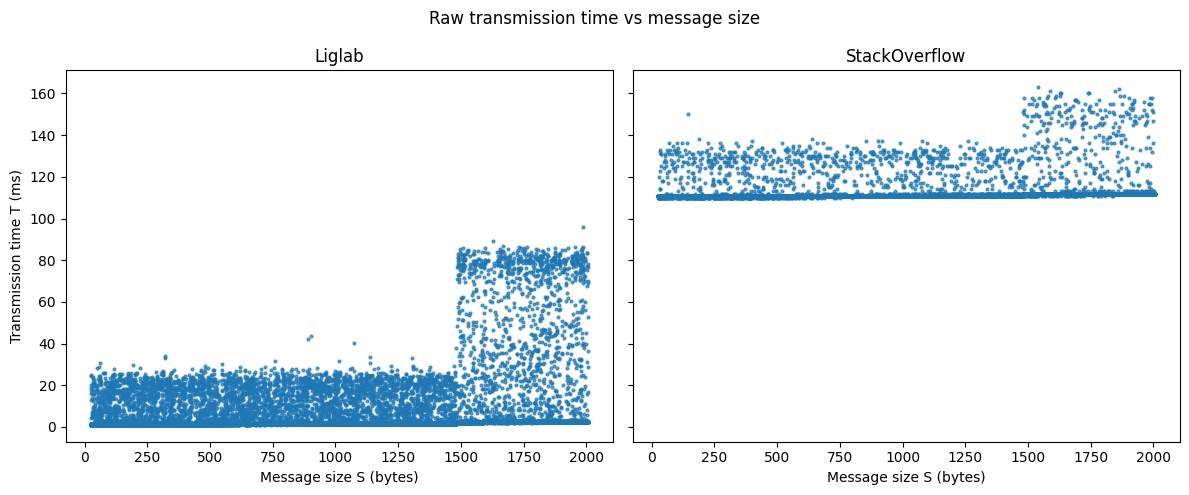

In [150]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].scatter(df_liglab_clean["bytes"], df_liglab_clean["time_ms"], s=4, alpha=0.7)
axes[0].set_title("Liglab")
axes[0].set_xlabel("Message size S (bytes)")
axes[0].set_ylabel("Transmission time T (ms)")

axes[1].scatter(df_stackoverflow_clean["bytes"], df_stackoverflow_clean["time_ms"], s=4, alpha=0.7)
axes[1].set_title("StackOverflow")
axes[1].set_xlabel("Message size S (bytes)")

plt.suptitle("Raw transmission time vs message size")
plt.tight_layout()
plt.show()

Although simple, this plot shows that for both datasets there the data can be divided in two separate clusters. There exists a clear value for the `message size` where the upper bound of the total `transmission time` increases without a clear explanation. 

The lower bound stays relatively stable between both clusters, it is possible to observe mainly on the `stackoverflow` dataset that there exists a small correlation between the `message size` and `transmission time`, which we will try to identify in the next sections using linear regression.
 

In [151]:
def detect_disruption(df, min_threshold=20.0):
    std_by_size = df.groupby("bytes")["time_ms"].std()
    sizes = std_by_size.index.values
    std_values = std_by_size.values
    diff_std = np.diff(std_values)
    valid_indices = np.where(diff_std >= min_threshold)[0]
    S_cut = sizes[valid_indices[0] + 1] if len(valid_indices) > 0 else None
    return S_cut

S_cut_liglab = detect_disruption(df_liglab_clean, min_threshold=20.0)
S_cut_so = detect_disruption(df_stackoverflow_clean, min_threshold=20.0)

print(f"LIGLab detected disruption size: {S_cut_liglab} bytes")
print(f"StackOverflow detected disruption size: {S_cut_so} bytes")


LIGLab detected disruption size: 1485 bytes
StackOverflow detected disruption size: 1515 bytes


Using the function below, we can identify the message size that triggers a significant increase in the upper bound of round-trip times. First, we calculate the standard deviation of transmission times for each message size. Then, we compute the difference between consecutive message sizes. By applying a threshold of 20 standard deviations, we can detect the first occurrence where this difference exceeds the threshold, which corresponds approximately to the breakpoint, the message size at which the variance suddenly increases.

In [155]:
import statsmodels.api as sm

# Breakpoints
S_cut_liglab = 1485
S_cut_so = 1515

# Linear regression function for T(S) = L + S/C
def estimate_latency_capacity(df):
    X = df['bytes'].values  # message size S
    y = df['time_ms'].values / 1000  # convert ms to seconds if needed
    X = sm.add_constant(X)  # adds intercept = L
    model = sm.OLS(y, X).fit()
    return model


Using the discovered breakpoint, we can try to fit a linear regression model onto the data in order to find the estimate latency and bandwidth of each cluster and location.

#### Messages on LigLab

In [160]:
before_liglab = df_liglab_clean[df_liglab_clean['bytes'] <= S_cut_liglab]
after_liglab = df_liglab_clean[df_liglab_clean['bytes'] > S_cut_liglab]

model_before_liglab = estimate_latency_capacity(before_liglab)
model_after_liglab = estimate_latency_capacity(after_liglab)

print("LIGLab regression before disruption:\n\n")
print(model_before_liglab.summary())

print("\n\nLIGLab regression after disruption:\n\n")
print(model_after_liglab.summary())

LIGLab regression before disruption:


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     21.64
Date:                Sat, 13 Dec 2025   Prob (F-statistic):           3.31e-06
Time:                        17:12:31   Log-Likelihood:             1.2369e+05
No. Observations:               31737   AIC:                        -2.474e+05
Df Residuals:                   31735   BIC:                        -2.473e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        